# Modelling Customer's Online Purchasing Intention with Regularized Logistic AdaBoost & XGBoost

## Motivation
Over the last couple of years, online shopping has become more and more prevalent in Australia, with events such as Cyber Monday, Single’s Day and Click Frenzy. It would be fascinating to see which online factors influences a customer’s purchasing decision.

Our aim is to see if we could model a customer's online purchasing intention using customer online behavioural data. Once we have our model, we would like to explain how features in our model would affect a customer's online purchasing intention.

## The Data
The data used in this analysis is the **Online Shoppers Purchasing Intention Dataset** provided by UC Irvine’s Machine Learning Repository. The dataset consists of 12,330 sessions with 10 numerical and 8 categorical features. Each session belong to a different user ending up with a purchase or without a purchase, indicated by the variable **Revenue**. If you’re curious and want more detail about what the data looks like and its features, you can check it out [here](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset#). 

Let’s start exploring our dataset.

In [40]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, linear_model
from sklearn.feature_selection import RFECV
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

In [109]:
# Read in dataset
file = "https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv"
df = pd.read_csv(file)
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [110]:
df.shape

(12330, 18)

## Data Preprocessing
First, let's have a look to see if features in our dataset have been assigned with the correct data types.

In [111]:
df.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

We see **OperatingSystems**, **Browser**, **Region** and **TrafficType** were assigned as integer data type when these are categorical variables. We also see **Weekend** and **Revenue** assigned as boolean data type when these are categorical. We will change these variables to object data type to reflect that they are categorical.

In [112]:
lst = ['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend', 'Revenue']
for i in lst:
    df[i] = df[i].astype(object)

In [113]:
df.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems            object
Browser                     object
Region                      object
TrafficType                 object
VisitorType                 object
Weekend                     object
Revenue                     object
dtype: object

Now let's have a look to see if there are any features with large % of missing values we would want to exclude from our Exploratory Data Analysis later on.

In [114]:
(df.isnull().sum(axis=0)/df.shape[0]).sort_values(ascending=False)

Revenue                    0.0
Weekend                    0.0
Administrative_Duration    0.0
Informational              0.0
Informational_Duration     0.0
ProductRelated             0.0
ProductRelated_Duration    0.0
BounceRates                0.0
ExitRates                  0.0
PageValues                 0.0
SpecialDay                 0.0
Month                      0.0
OperatingSystems           0.0
Browser                    0.0
Region                     0.0
TrafficType                0.0
VisitorType                0.0
Administrative             0.0
dtype: float64

We could see there are no missing values in any of our features.

## Exploratory Data Analysis
### Summary Statistics
Let's first have a look at the summary statistics.

In [115]:
df.describe(include='all')

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330,12330.0,12330.0,12330.0,12330.0,12330,12330,12330
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,8.0,13.0,9.0,20.0,3,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May,2.0,2.0,1.0,2.0,Returning_Visitor,False,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3364,6601.0,7961.0,4780.0,3913.0,10551,9462,10422
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157213,0.016813,0.050000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We see customers spend significantly more time on product related pages (**ProductRelated_Duration**) than on administrative pages (**Administrative_Duration**) or informational pages (**Informational_Duration**). Let's have a look if spending significantly more time on product related pages translates to a purchase or not.

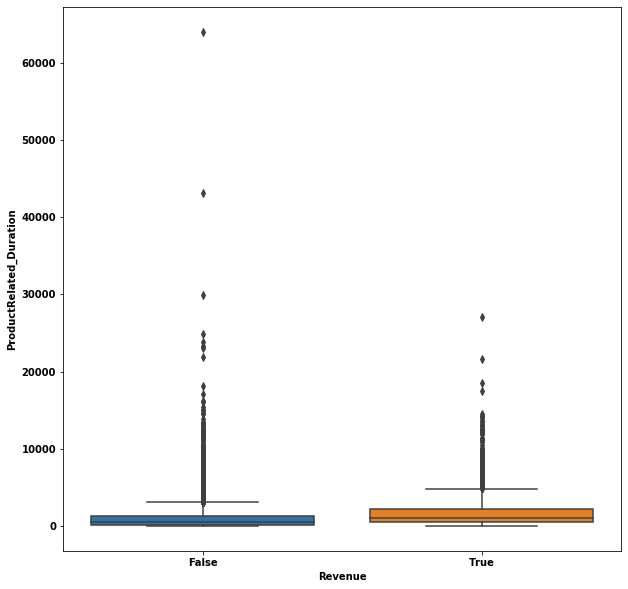

In [116]:
# Plot boxplot
plt.figure(figsize=(10,10))
sns.boxplot(x='Revenue',  y='ProductRelated_Duration', data=df)

We see the two boxplots overlaps which means time spent on product related pages doesn't necessarily result in a purchase. 

Since customers are spending most of their time on product related pages where it doesn't necessarily result in a purchase, it might be beneficial for the e-commerce website to produce pop-up ads when customers are on product related pages, to increase a customer's purchasing intention.

From the summary statistics, we also see the highest number of visits to the e-commerce website occurs during May. Lets investigate further if these higher number of visits in May results in a purchase or not.

In [117]:
df['Month'].unique()

array(['Feb', 'Mar', 'May', 'Oct', 'June', 'Jul', 'Aug', 'Nov', 'Sep',
       'Dec'], dtype=object)

In [118]:
# Code Month to numerical values
df['Month_no'] = df['Month'].map({'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'June': 6, 
                                  'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12})

In [119]:
# Create dataframe for total number of visits per month
df1 = df[['Month', 'Month_no', 'Revenue']]
df2 = df1.groupby(['Month', 'Month_no'], as_index=False).count().sort_values(by='Month_no')

# Create dataframe for number of visits ending up without a purchase per month
df3 = df1[df1['Revenue'] == False]
df4 = df3.groupby(['Month', 'Month_no'], as_index=False).count().sort_values(by='Month_no')

# Create dataframe for number of visits ending up with a purchase per month
df5 = df1[df1['Revenue'] == True]
df6 = df5.groupby(['Month', 'Month_no'], as_index=False).count().sort_values(by='Month_no')

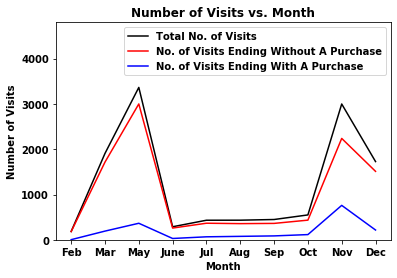

In [122]:
# Plot line plot
plt.plot(df2['Month'], df2['Revenue'], label='Total No. of Visits', color='black')
plt.plot(df4['Month'], df4['Revenue'], label='No. of Visits Ending Without A Purchase', color='red')
plt.plot(df6['Month'], df6['Revenue'], label='No. of Visits Ending With A Purchase', color='blue')
plt.xlabel('Month')
plt.ylabel('Number of Visits')
plt.title('Number of Visits vs. Month')
plt.legend()
plt.ylim(0, 4800)
plt.show()

First, we note that there are missing data for two months, January and April. We also see two peaks which occurs in May and November. We see majority of the total number of visits occuring during May does not result in a purchase (since the red line peak is close to the black line peak in May). We see it is slightly better during November, where more visits result in a purchase (since the red line peak is further from the black line peak in November).

Looking at **Revenue** in the summary statistics, we see there is a high proportion of visits results without a purchase compared to with a purchase. Let's have a look at **Revenue** using a bar chart.

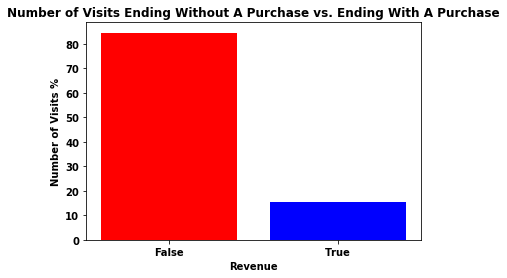

In [123]:
# Plot bar chart
plt.bar(df['Revenue'].unique()[0], (df['Revenue'].value_counts()[0]/df.shape[0])*100, color='red')
plt.bar(df['Revenue'].unique()[1], (df['Revenue'].value_counts()[1]/df.shape[0])*100, color='blue')
plt.xticks(np.arange(len(df['Revenue'].unique())), df['Revenue'].unique())
plt.xlabel('Revenue')
plt.ylabel('Number of Visits %')
plt.title('Number of Visits Ending Without A Purchase vs. Ending With A Purchase')
plt.show()

We see only about 15% of visits results in a purchase compared to 85% of visits with no purchase. Because of the low number of observations in one of the target class this could cause an imbalance issue to occur during our model building process. We will keep this in mind for now and consider using boosting techniques if our model does not perform adequately.

Since there are only two classes in our target variable **Revenue**, we will choose logistic regression (with binary classes) to build our model.

### Correlation Analysis
Now let's have a look at the correlation between features, using a correlation heatmap.

In [124]:
# Cast features to integers to calculate correlation
df['OperatingSystems_no'] = df['OperatingSystems'].astype(int)
df['Browser_no'] = df['Browser'].astype(int)
df['Region_no'] = df['Region'].astype(int)
df['TrafficType_no'] = df['TrafficType'].astype(int)
df['Weekend_no'] = df['Weekend'].astype(int)

In [125]:
# Code VisitorType to numerical values
df['VisitorType'].unique()

array(['Returning_Visitor', 'New_Visitor', 'Other'], dtype=object)

In [126]:
df['VisitorType_no'] = df['VisitorType'].map({'Returning_Visitor': 1, 'New_Visitor': 2, 'Other': 3})

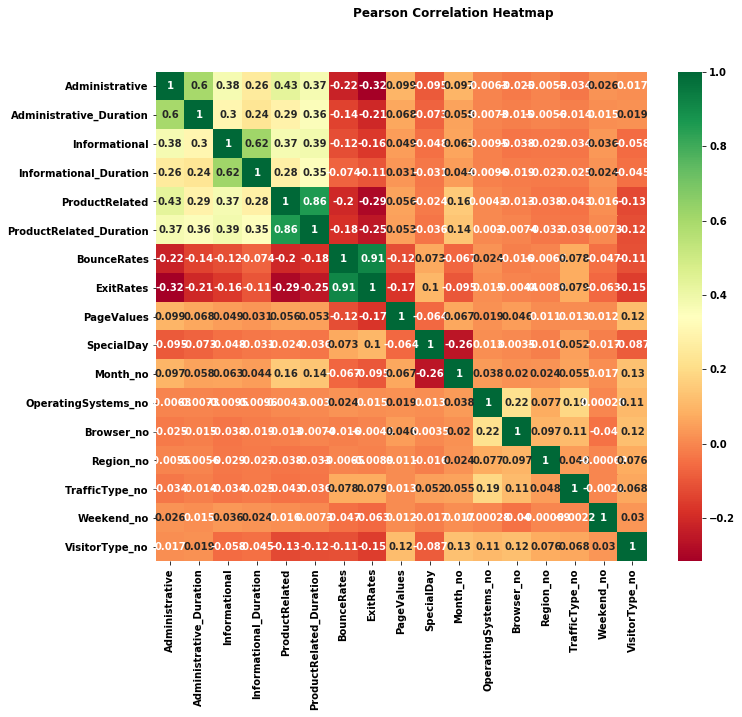

In [127]:
# Plot correlation heatmap
plt.figure(figsize=(11, 9))
sns.heatmap(df.drop(['Revenue'], axis=1).corr(), annot=True, cmap="RdYlGn")
plt.suptitle("Pearson Correlation Heatmap")
plt.show()

We see there are strong correlation between some features. For example, **ProductRelated** and **ProductRelated_Duration**, **BounceRates** and **ExitRates** are strongly correlated. We will keep these collinearities between our features in mind for now.

## Feature Selection
After exploring our data, let us now select which features to go into our model.

We will use scikit-learn's **RFECV** package in selecting our features. RFE stands for recursive feature elimination. This method simply works by first considering all features to be fitted into our model, then the least important feature is removed. This procedure is repeated, where at each step fitting the previous set of features and removing one feature at a time, until the chosen desired number of features is eventually reached.

We will use cross-validation in **RFECV** (with default 5-folds) to find the optimal desired number of features to select. We will also use logistic regression as the base estimator in **RFECV**, as the final model we want to build is of the same type.

In [128]:
# Create feature matrix excluding any duplicate object data type features
X_fs = df.select_dtypes(exclude=['object']).values

# Create target vector
Y_fs = df['Revenue'].astype(int).values

# penalty='none' chosen to exclude regularization at this stage
# max_iter=10000 chosen to ensure there is enough iterations for convergence
# scoring='f1' chosen to return F1-score
# n_jobs=-1 chosen to use all CPU processors for faster processsing
rfecv = RFECV(linear_model.LogisticRegression(penalty='none', max_iter=10000), scoring='f1', n_jobs=-1).fit(X_fs, Y_fs)

Now, let's find the optimal desired number of features to select.

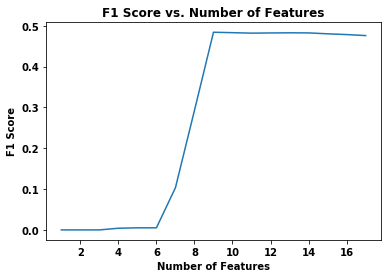

In [131]:
# Plot F1 score vs. number of features
plt.plot(np.arange(1, 18, 1), rfecv.grid_scores_[0:17])
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Number of Features')
plt.show()

From the plot, we see the F1 score initially increases (due to underfitting of our model) until it reaches a maximum at 9 features and then no futher improvement or a slight decrease (due to overfitting of our model). We will choose 9 as the desired number of features to go into our model.

Let's have a look at which 9 features were selected by **RFECV**.

In [129]:
df_fs = pd.DataFrame(rfecv.support_, index=df.select_dtypes(exclude=['object']).columns, columns=['Feature Selected?'])
df_fs

,Feature Selected?
Administrative,False
Administrative_Duration,False
Informational,True
Informational_Duration,False
ProductRelated,False
ProductRelated_Duration,False
BounceRates,True
ExitRates,True
PageValues,True
SpecialDay,True


We can see **BounceRates** and **ExitRates** were selected. However our Correlation Analysis shows these two features are highly correlated. There are no strong correlation between any of the other selected features.

To avoid collinearity issues in our model, we will drop either **BounceRates** or **ExitRates**. To see which feature to drop, we will look at the feature importances given by the model coefficients in **RFECV**.

In [203]:
df_fi = pd.DataFrame(rfecv.estimator_.coef_.T, index=df_fs[df_fs['Feature Selected?']==True].index, 
                     columns=['Feature Importances'])
df_fi

,Feature Importances
Informational,0.096305
BounceRates,-1.504416
ExitRates,-19.475710
PageValues,0.079582
SpecialDay,-0.382395
Month_no,0.097641
OperatingSystems_no,-0.091135
Weekend_no,0.131792
VisitorType_no,0.104333


We see the coefficient for **BounceRates** is closer to 0 than the coefficient for **ExitRates**. We will drop **BounceRates**.

In [159]:
lst_fs = df_fs[df_fs['Feature Selected?']==True].index.tolist()
X_fs = df[lst_fs].drop('BounceRates', axis=1)

We now have 8 features selected to go into our model.

## Feature Engineering
Let us now dummy code the categorical features selected in the Feature Selection step.

In [161]:
# Cast categorical features to object to perform one-hot encoding
X_fs.loc[:,'Month_no'] = X_fs.loc[:,'Month_no'].astype(object)
X_fs.loc[:,'OperatingSystems_no'] = X_fs.loc[:,'OperatingSystems_no'].astype(object)
X_fs.loc[:,'Weekend_no'] = X_fs.loc[:,'Weekend_no'].astype(object)
X_fs.loc[:,'VisitorType_no'] = X_fs.loc[:,'VisitorType_no'].astype(object)

X_fe = pd.get_dummies(X_fs)

## Model Development

Let's start building our logistic regression model. 

First, we split our dataset into 80% training and 20% testing.

In [189]:
# test_size=0.2 chosen to get 80/20 split
# random_state=2 chosen so the results are reproducible if the code is rerun
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_fe.values, Y_fs, test_size=0.2, random_state=2)

We use scikit-learn's **LogisticRegression** to build our model.

In [183]:
# penalty='none' chosen to exclude any regularization at this stage
# max_iter=10000 chosen to ensure there is enough iterations for convergence
model = linear_model.LogisticRegression(penalty='none', max_iter=10000).fit(X_train, Y_train)

F1 score on test set:

In [204]:
Y_hat = model.predict(X_test)
print('F1 score: %.3f' % f1_score(Y_test, Y_hat, average='weighted'))

F1 score: 0.874


Our F1 score of 87.4% is quite good to start off with!

## Model Refinement

Let's have a look to see if we could refine our model by adjusting for any presence of overfitting to the training set or for any remaining collinearities present in our selected features. To do this, we will use **ElasticNet**, which consists of two parts:
- **Lasso** regression which adds a L1 regularization term to the loss function.
- **Ridge** regression which adds a L2 regularization term to the loss function.

We will use scikit-learn's **LogisticRegressionCV** to perform **ElasticNet**. This package has the option to choose the value of two hyperparameters to control for **ElasticNet**'s regularization:
- the **ElasticNet** regularization term, L1-ratio (=ratio of L1 to L2 term).
- the inverse of regularization strength, C (where smaller values specify stronger regularization). 

We will use cross-validation in **LogisticRegressionCV** (with default 5-folds) to find the optimal values for L1-ratio and C.

In [187]:
# Create a list of values [0, 0.1, 0.2,...,1.0] for L1-ratio
lst_l1_ratio = np.linspace(0, 1, 11).tolist()

In [188]:
# Cs=10 chosen to use the package's default list of values for C
# penalty='elasticnet' chosen to apply L1-ratio regularization term to the loss function
# scoring='f1' chosen to return F1-score
# solver='saga' algorithm chosen to apply ElasticNet
# max_iter=10000 chosen to ensure there is enough iterations for convergence
# n_jobs=-1 chosen to use all CPU processors for faster processsing
# l1_ratios=lst_l1_ratio to use the list of L1-ratio values we have created
model_ref = linear_model.LogisticRegressionCV(Cs=10, penalty='elasticnet', scoring='f1', solver='saga', max_iter=10000, \ 
                                              n_jobs=-1, l1_ratios=lst_l1_ratio).fit(X_train, Y_train)

In [201]:
print('Optimal L1-ratio: %.3f' % model_ref.l1_ratio_[0,])
print('Optimal C: %.3f' % model_ref.C_[0,])

Optimal L1-ratio: 0.000
Optimal C: 0.359


We see the optimal value for L1-ratio is 0 which means our model is refined completely using **Ridge** regression.

F1 score on test set:

In [205]:
Y_hat = model_ref.predict(X_test)
print('F1 score: %.3f' % f1_score(Y_test, Y_hat, average='weighted'))

F1 score: 0.875


The F1 score is close to the F1 score of 87.4% prior to refinement, which means our model building process before Model Refinement had done a good job in not overfitting to the training set and taken into account collinearities in the features.

With an F1 score of 87.5%, our model performs quite well even though we had a slight inbalance in our target variable as noted earlier. We will still however, see if we could further improve the performance by applying boosting to our model.

## AdaBoost

**Adaboost** is a boosting technique which works by successively giving more weights to misclassified samples in previous ensembles of weak estimators, in the hope that this would improve the performance of the model.

To find the optimal number of weak estimators to use, we will perform **Adaboost** on our refined model by fitting an increasing number of weak estimators at each step, say between 5 to 200 weak estimators (incremented by 5 at each step) and obtain the test set performance at each step. We then plot the test set performance againts the number of weak estimators and choose the optimal number of weak estimators when the test set performance is at a maximum.

We will use scikit-learn's **AdaBoostClassifier** to do this.

In [18]:
# Create a list of values [5, 10, 15,...,200] for the number of weak estimators
lst_n_estimators = np.arange(5,205,5).tolist()

# Initialize empty list for the test set F1 score
f1_sc = []

# penalty='elasticnet' chosen to apply L1-ratio regularization term to the loss function
# C=0.359 chosen as this is the optimal C value
# solver='saga' algorithm chosen to apply ElasticNet
# max_iter = 10000000 chosen to ensure there is enough iterations for convergence
# warm_start=True chosen to reuse the previous fit model for faster processsing
# l1_ratio = 0.0 chosen as this is the optimal L1-ratio value
# n_estimators=i to iterate through the list of number of weak estimators [5, 10, 15,...,200]
# learning_rate=0.01 set to a small value to ensure global minimum is reached when optimizing loss function
# random_state=3 chosen so the results are reproducible if the code is rerun
for i in lst_n_estimators:
    adaboost_model = AdaBoostClassifier(base_estimator=linear_model.LogisticRegression(penalty='elasticnet', C=0.359, \
                                                                                       solver='saga', max_iter=10000000, \
                                                                                       warm_start=True, l1_ratio=0.0), \
                                        n_estimators=i, learning_rate=0.01, random_state=3).fit(X_train, Y_train.reshape(-1))
    Y_hat = adaboost_model.predict(X_test)
    f1_sc.append(f1_score(Y_test, Y_hat, average='weighted'))

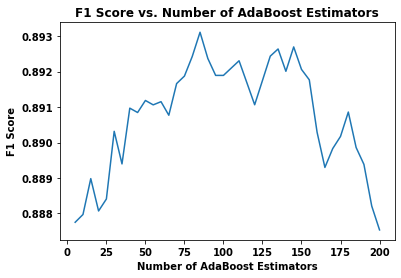

In [19]:
# Plot F1 score vs. number of Adaboost estimators
plt.plot(np.arange(5,205,5), f1_sc)
plt.xlabel('Number of AdaBoost Estimators')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Number of AdaBoost Estimators')
plt.show()

As the number of estimators increases, we see the F1 score initially increases (due to underfitting of our model to misclassified samples) until it reaches a maximum somewhere in between 75 to 100 estimators and then it decreases (due to overfitting of our model to misclassified samples).

Let's have a look at how many estimators occurs at this maximum F1 score.

In [37]:
np.arange(5,205,5)[np.argmax(np.array(f1_sc), axis=0)], np.array(f1_sc)[np.argmax(np.array(f1_sc), axis=0)]

(85, 0.8931104078959075)

The maximum F1 score of 89.3% occurs where there are 85 estimators.

This is an improvement to our refined model which has an F1 score of 87.5%!

Let's have a look at the AUC score on the test set.

In [215]:
# Fit the same AdaBoost model but with n_estimators=85
adaboost_model = AdaBoostClassifier(base_estimator=linear_model.LogisticRegression(penalty='elasticnet', C=0.359, \
                                                                                   solver='saga', max_iter=10000000, \
                                                                                   warm_start=True, l1_ratio=0.0), \
                                    n_estimators=85, learning_rate=0.01, random_state=3).fit(X_train, Y_train.reshape(-1))
Y_hat_prob = adaboost_model.predict_proba(X_test)
print('AUC score: %.3f' % roc_auc_score(Y_test, Y_hat_prob[:,1]))

AUC score: 0.814


## XgBoost

Let's do a quick baseline comparison of our model with the popular **XgBoost** model. **XgBoost** is a tree based model which applies a boosting technique which works by successively adding a regularization term to the loss function in a step-wise manner to previous ensembles of weak estimators and then optimizing this loss function, in the hope that this would improve the performance of the model.

We will use **XGBClassifier** in the **XgBoost** library and using most of the package's default hyperparameter values.

In [252]:
# learning_rate=0.01 set to a small value to ensure global minimum is reached when optimising loss function
# objective='binary:logistic' chosen as our logistic model is of the same type for fair comparison
# booster='gblinear' chosen as our logistic model is of a linear type for fair comparison
# reg_alpha = 0.0 chosen as the optimal L1-ratio value of our logistic model is 0 for fair comparison
xgboost_model = XGBClassifier(learning_rate=0.01, objective='binary:logistic', booster='gblinear', reg_alpha=0.0) \
                .fit(X_train, Y_train)

F1 score on test set:

In [221]:
Y_hat = xgboost_model.predict(X_test)
print('F1 score: %.3f' % f1_score(Y_test, Y_hat, average='weighted'))

F1 score: 0.828


AUC score on test set:

In [222]:
Y_hat_prob = xgboost_model.predict_proba(X_test)
print('AUC score: %.3f' % roc_auc_score(Y_test, Y_hat_prob[:,1]))

AUC score: 0.818


The F1 score of our **Regularized Logistic AdaBoost** model (at 89.3%) is higher than that of the **XgBoost** model (at 82.8%)!

The AUC score for both models are about the same (at 81.4% and 81.8%) which indicates overall both models perform the similarly. We have done a fairly good job in building our **Regularized Logistic AdaBoost** model matching that of the **XgBoost** model!

## Post-Model Analysis

Using the **Regularized Logistic AdaBoost** model that we have built, let's see if we could derive any insights about our data.

We are interested to see what customer's online purchasing intention are like during weekdays and weekends throughout each month of the year.

In [44]:
# Create a dataframe of dummy coded values for each combination of Weekend and Month
X_Weekend_Month = np.zeros((20,27))
df_Weekend_Month = pd.DataFrame(X_Weekend_Month, columns=X_fe.columns)
df_Weekend_Month.loc[0, ['Weekend_0', 'Month_no_2']] = 1
df_Weekend_Month.loc[1, ['Weekend_1', 'Month_no_2']] = 1
df_Weekend_Month.loc[2, ['Weekend_0', 'Month_no_3']] = 1
df_Weekend_Month.loc[3, ['Weekend_1', 'Month_no_3']] = 1
df_Weekend_Month.loc[4, ['Weekend_0', 'Month_no_5']] = 1
df_Weekend_Month.loc[5, ['Weekend_1', 'Month_no_5']] = 1
df_Weekend_Month.loc[6, ['Weekend_0', 'Month_no_6']] = 1
df_Weekend_Month.loc[7, ['Weekend_1', 'Month_no_6']] = 1
df_Weekend_Month.loc[8, ['Weekend_0', 'Month_no_7']] = 1
df_Weekend_Month.loc[9, ['Weekend_1', 'Month_no_7']] = 1
df_Weekend_Month.loc[10, ['Weekend_0', 'Month_no_8']] = 1
df_Weekend_Month.loc[11, ['Weekend_1', 'Month_no_8']] = 1
df_Weekend_Month.loc[12, ['Weekend_0', 'Month_no_9']] = 1
df_Weekend_Month.loc[13, ['Weekend_1', 'Month_no_9']] = 1
df_Weekend_Month.loc[14, ['Weekend_0', 'Month_no_10']] = 1
df_Weekend_Month.loc[15, ['Weekend_1', 'Month_no_10']] = 1
df_Weekend_Month.loc[16, ['Weekend_0', 'Month_no_11']] = 1
df_Weekend_Month.loc[17, ['Weekend_1', 'Month_no_11']] = 1
df_Weekend_Month.loc[18, ['Weekend_0', 'Month_no_12']] = 1
df_Weekend_Month.loc[19, ['Weekend_1', 'Month_no_12']] = 1

In [228]:
# Obtain the probability of a purchase for each combination of Weekend and Month
Y_hat_prob = adaboost_model.predict_proba(df_Weekend_Month.values)

In [251]:
# Create dataframe sorted by probability of a purchase
lst_Weekend_Month = [
['No', 'Feb'],
['Yes', 'Feb'],
['No', 'Mar'],
['Yes', 'Mar'],
['No', 'May'],
['Yes', 'May'],
['No', 'Jun'],
['Yes', 'Jun'],
['No', 'Jul'],
['Yes', 'Jul'],
['No', 'Aug'],
['Yes', 'Aug'],
['No', 'Sep'],
['Yes', 'Sep'],
['No', 'Oct'],
['Yes', 'Oct'],
['No', 'Nov'],
['Yes', 'Nov'],
['No', 'Dec'],
['Yes', 'Dec']
]

arr_Weekend_Month_Y_hat_prob = np.column_stack((np.array(lst_Weekend_Month), np.around(Y_hat_prob[:,1]*100, decimals=3)))
pd.DataFrame(arr_Weekend_Month_Y_hat_prob, columns=['Weekend', 'Month', 'Probability of A Purchase (%)']) \
            .sort_values(by='Probability of A Purchase (%)', ascending=False)

,Weekend,Month,Probability of A Purchase (%)
1,Yes,Feb,48.722
7,Yes,Jun,48.717
13,Yes,Sep,48.711
11,Yes,Aug,48.71
9,Yes,Jul,48.708
15,Yes,Oct,48.705
19,Yes,Dec,48.603
3,Yes,Mar,48.583
17,Yes,Nov,48.578
5,Yes,May,48.465


The table above shows the chance of a customer making an online purchase (in %) when visiting the e-commerce website during a weekday and weekend for each month, sorted by most likely to least likely to make a purchase.

Our model shows a customer is more likely to make an online purchase on the weekend rather than a weekday across all months.

Surprisingly, even though the two peaks in May and November we observed earlier has the highest number of visits to the e-commerce website, our model shows the chance of a customer making an online purchase during these 2 months are the lowest compared to the other months.

If the e-commerce website intends to carry out sales or promotions to entice customers to make a purchase, we would recommend the website to do this during the other months which are not in May or November, and on weekends, since customers who visits the website are more likely to make an online purchase on weekends during months not in May or November.